In [60]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
import pickle

from PIL import ImageColor
import matplotlib.colors
from sklearn.preprocessing import StandardScaler
from utils import LATENT_FEATURES_DIR, RESULTS_DIR, SUBJECTS, FMRI_BETAS_SURFACE_DIR, STIM_INFO_PATH, COCO_IMAGES_DIR, METRIC_DIFF_MOD_AGNOSTIC_MOD_SPECIFIC, METRIC_CROSS_DECODING, RIDGE_DECODER_ATTN_MOD_OUT_DIR, ADDITIONAL_TEST_SUBJECTS
from analyses.decoding.ridge_regression_decoding import NUM_CV_SPLITS, pairwise_accuracy
from data import MODALITY_AGNOSTIC, MODALITY_SPECIFIC_IMAGES, MODALITY_SPECIFIC_CAPTIONS, TRAINING_MODES, CAPTION, IMAGE, TEST_SPLITS
from eval import ACC_MODALITY_AGNOSTIC, ACC_CAPTIONS, ACC_IMAGES, ACC_CROSS_IMAGES_TO_CAPTIONS, ACC_CROSS_CAPTIONS_TO_IMAGES, ACC_IMAGERY, ACC_IMAGERY_WHOLE_TEST, get_distance_matrix, dist_mat_to_pairwise_acc
from scipy.stats import ttest_rel
import statsmodels.formula.api as smf



In [88]:
def load_results_data():
    data = []

    result_files = sorted(glob(f"{RIDGE_DECODER_ATTN_MOD_OUT_DIR}/*/*/*/results.csv"))
    for result_file_path in tqdm(result_files):
        results = pd.read_csv(result_file_path)
        data.append(results)

    data = pd.concat(data, ignore_index=True)
    data["mask"] = data["mask"].fillna("whole_brain")

    return data

data = load_results_data()

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
display(data)

print(f"Subjects: {data.subject.unique()}")

100%|██████████| 13/13 [00:00<00:00, 281.00it/s]


,metric,value,standardized_predictions,latents,model,subject,features,test_features,vision_features,lang_features,training_mode,training_splits,mask,num_voxels,surface,resolution
0,test_image,0.893168,False,limited_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,327684,True,fsaverage7
1,test_image,0.910352,True,limited_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,327684,True,fsaverage7
2,test_image,0.906909,False,all_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,327684,True,fsaverage7
3,test_image,0.910304,True,all_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,327684,True,fsaverage7
4,test_caption,0.765217,False,limited_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,327684,True,fsaverage7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,imagery_weak,0.899592,True,limited_candidate_latents,imagebind,sub-07,avg,avg,vision_features_cls,lang_features_cls,images,train,whole_brain,327684,True,fsaverage7
438,imagery_weak,0.648361,False,all_candidate_latents,imagebind,sub-07,avg,avg,vision_features_cls,lang_features_cls,images,train,whole_brain,327684,True,fsaverage7
439,imagery_weak,0.885574,True,all_candidate_latents,imagebind,sub-07,avg,avg,vision_features_cls,lang_features_cls,images,train,whole_brain,327684,True,fsaverage7
440,imagery,0.666667,all_imagery,limited_candidate_latents,imagebind,sub-07,avg,avg,vision_features_cls,lang_features_cls,images,train,whole_brain,327684,True,fsaverage7


Subjects: ['sub-01' 'sub-02' 'sub-07']


In [94]:
print(data[(data.subject == 'sub-01') & (data.model == 'imagebind') & (data.training_mode == 'agnostic') & (data['mask'] == 'whole_brain') & (data.standardized_predictions == 'True') & (data.training_splits == 'train')][['metric', 'value', 'latents']]) #
# print(data[(data.subject == 'sub-01') & (data.model == 'imagebind') & (data.training_mode == 'agnostic') & (data['mask'] == 'whole_brain') & (data.training_splits == 'train') & (data.latents == 'all_candidate_latents')][['metric', 'value', 'latents', 'standardized_predictions']]) #

                     metric     value                    latents
1                test_image  0.910352  limited_candidate_latents
3                test_image  0.910304      all_candidate_latents
5              test_caption  0.826915  limited_candidate_latents
7              test_caption  0.827635      all_candidate_latents
9       test_image_attended  0.907660  limited_candidate_latents
11      test_image_attended  0.908782      all_candidate_latents
13    test_caption_attended  0.818634  limited_candidate_latents
15    test_caption_attended  0.819087      all_candidate_latents
17    test_image_unattended  0.888406  limited_candidate_latents
19    test_image_unattended  0.893911      all_candidate_latents
21  test_caption_unattended  0.650725  limited_candidate_latents
23  test_caption_unattended  0.651874      all_candidate_latents
25                  imagery  1.000000  limited_candidate_latents
27                  imagery  0.868852      all_candidate_latents
29             imagery_we

In [41]:
filtered = data.copy()

LATENT_MODE = 'all_candidate_latents'
# LATENT_MODE = 'limited_candidate_latents'
MASK = 'whole_brain'
TRAINING_SPLITS = 'train'

filtered = filtered[filtered.standardized_predictions == 'True']
filtered = filtered[filtered.training_splits == TRAINING_SPLITS]
filtered = filtered[filtered.latents == LATENT_MODE]
filtered = filtered[filtered['mask'] == MASK]

# print(filtered.groupby(['metric', 'training_mode']).agg(num_subjects=('value', 'size')).reset_index())
NUM_SUBJECTS = 3 # len(ADDITIONAL_TEST_SUBJECTS)
assert len(filtered) == NUM_SUBJECTS * len(filtered.metric.unique()) * len(filtered.training_mode.unique())

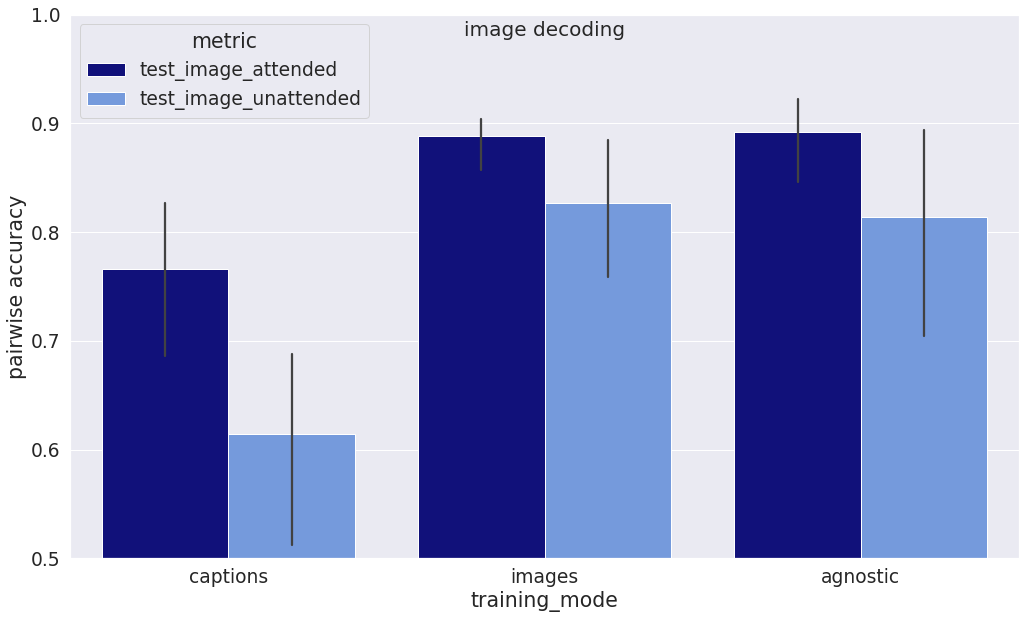

In [81]:
to_plot = filtered.copy()

ORDER = ['captions', 'images', 'agnostic']
HUE_ORDER = ['test_image_attended', 'test_image_unattended']#, 'imagery', 'imagery_weak'] #'test_image', 
PALETTE = ['darkblue', 'cornflowerblue'] #blue

to_plot = to_plot[to_plot.metric.isin(HUE_ORDER)]

sns.set(font_scale=1.7)
plt.figure(figsize=(17, 10))
plt.title('image decoding', y=0.95, fontsize=20)
ax = sns.barplot(data=to_plot, x="training_mode", y="value", hue="metric", order=ORDER, hue_order=HUE_ORDER, palette=PALETTE)
plt.ylim((0.5, 1))
plt.ylabel('pairwise accuracy')
plt.savefig(os.path.join(RESULTS_DIR, f"attention_modulation_images.png"), bbox_inches='tight', pad_inches=0, dpi=300)



## hypothesis: mod-agnostic decoders (and cross-decoding) should suffer more from missing attention

In [80]:
for_stats = to_plot[to_plot.training_mode.isin(['images', 'agnostic'])]
# display(for_stats)
# print(ttest_rel(for_stats[for_stats.metric == 'test_image_attended'].value, for_stats[for_stats.metric == 'test_image_unattended'].value))

for_stats = for_stats[['model', 'subject', 'training_mode', 'value', 'metric']]

mod = smf.mixedlm("value ~ metric * training_mode", for_stats, groups=for_stats["subject"]).fit()

print("=" * 50 + "\nGLM\n" + "=" * 50)
print(mod.summary())
print('pvalues:\n', mod.pvalues)
print('\n')


GLM
                              Mixed Linear Model Regression Results
Model:                            MixedLM                Dependent Variable:                value 
No. Observations:                 12                     Method:                            REML  
No. Groups:                       3                      Scale:                             0.0033
Min. group size:                  4                      Log-Likelihood:                    8.6704
Max. group size:                  4                      Converged:                         Yes   
Mean group size:                  4.0                                                             
--------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept                            

/home/mitja/anaconda3/envs/multimodal_decoding_additional_test/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


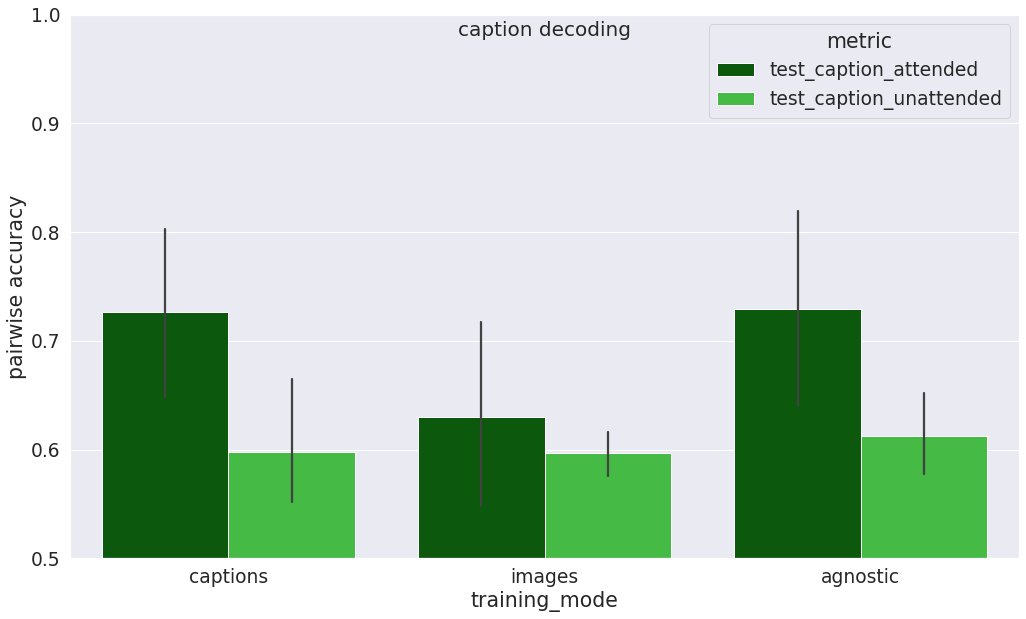

In [84]:
to_plot = filtered.copy()

ORDER = ['captions', 'images', 'agnostic']
HUE_ORDER = ['test_caption_attended', 'test_caption_unattended']#, 'imagery', 'imagery_weak'] #'test_caption', 
PALETTE = ['darkgreen', 'limegreen'] #'green', 

to_plot = to_plot[to_plot.metric.isin(HUE_ORDER)]

sns.set(font_scale=1.7)
plt.figure(figsize=(17,10))
plt.title('caption decoding', y=0.95, fontsize=20)
ax = sns.barplot(data=to_plot, x="training_mode", y="value", hue="metric", order=ORDER, hue_order=HUE_ORDER, palette=PALETTE)
plt.ylabel('pairwise accuracy')
plt.ylim((0.5, 1))
plt.savefig(os.path.join(RESULTS_DIR, f"attention_modulation_captions.png"), bbox_inches='tight', pad_inches=0, dpi=300)


In [86]:
for_stats = to_plot[to_plot.training_mode.isin(['captions', 'agnostic'])]
display(for_stats)
# print(ttest_rel(for_stats[for_stats.metric == 'test_caption_attended'].value, for_stats[for_stats.metric == 'test_caption_unattended'].value))

for_stats = for_stats[['model', 'subject', 'training_mode', 'value', 'metric']]

mod = smf.mixedlm("value ~ metric * training_mode", for_stats, groups=for_stats["subject"]).fit()

print("=" * 50 + "\nGLM\n" + "=" * 50)
print(mod.summary())
print('pvalues:\n', mod.pvalues)
print('\n')



,metric,value,standardized_predictions,latents,model,subject,features,test_features,vision_features,lang_features,training_mode,training_splits,mask,num_voxels,surface,resolution
15,test_caption_attended,0.819087,True,all_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,327684,True,fsaverage7
23,test_caption_unattended,0.651874,True,all_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,327684,True,fsaverage7
117,test_caption_attended,0.640281,True,all_candidate_latents,imagebind,sub-02,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,327684,True,fsaverage7
125,test_caption_unattended,0.608197,True,all_candidate_latents,imagebind,sub-02,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,327684,True,fsaverage7
151,test_caption_attended,0.728103,True,all_candidate_latents,imagebind,sub-07,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,327684,True,fsaverage7
159,test_caption_unattended,0.577166,True,all_candidate_latents,imagebind,sub-07,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,327684,True,fsaverage7
253,test_caption_attended,0.803044,True,all_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,captions,train,whole_brain,327684,True,fsaverage7
261,test_caption_unattended,0.664871,True,all_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,captions,train,whole_brain,327684,True,fsaverage7
287,test_caption_attended,0.648595,True,all_candidate_latents,imagebind,sub-02,avg,avg,vision_features_cls,lang_features_cls,captions,train,whole_brain,327684,True,fsaverage7
295,test_caption_unattended,0.551874,True,all_candidate_latents,imagebind,sub-02,avg,avg,vision_features_cls,lang_features_cls,captions,train,whole_brain,327684,True,fsaverage7


GLM
                                Mixed Linear Model Regression Results
Model:                             MixedLM                 Dependent Variable:                 value  
No. Observations:                  12                      Method:                             REML   
No. Groups:                        3                       Scale:                              0.0011 
Min. group size:                   4                       Log-Likelihood:                     11.0341
Max. group size:                   4                       Converged:                          Yes    
Mean group size:                   4.0                                                                
------------------------------------------------------------------------------------------------------
                                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------------------

/home/mitja/anaconda3/envs/multimodal_decoding_additional_test/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


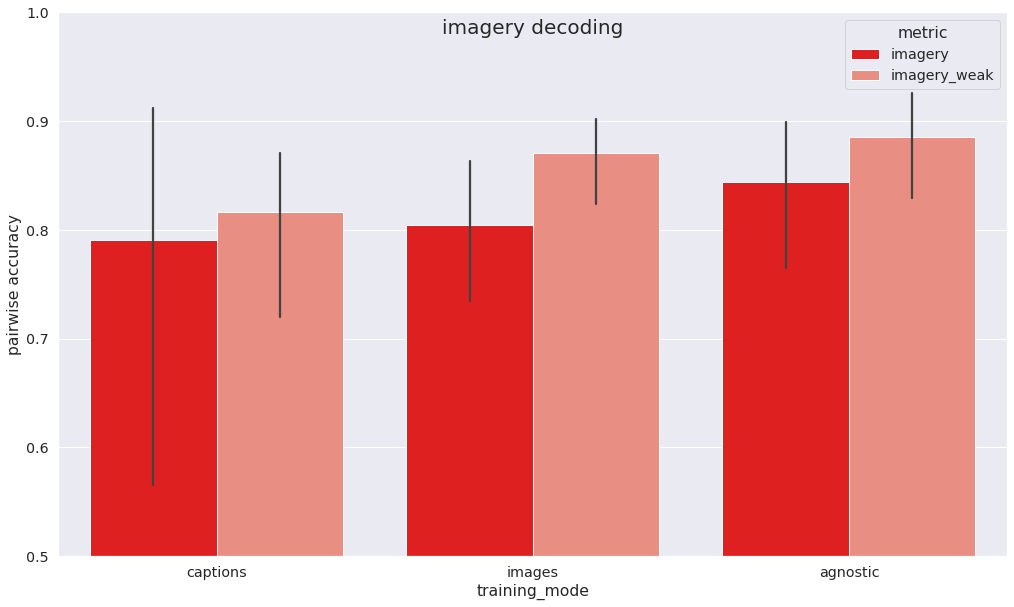

In [36]:
to_plot = filtered.copy()

ORDER = ['captions', 'images', 'agnostic']
HUE_ORDER = ['imagery', 'imagery_weak']
PALETTE = ['red', 'salmon']
sns.set(font_scale=1.3)
plt.figure(figsize=(17,10))
plt.title('imagery decoding', y=0.95, fontsize=20)

ax = sns.barplot(data=to_plot, x="training_mode", y="value", hue="metric", order=ORDER, hue_order=HUE_ORDER, palette=PALETTE)
plt.ylabel('pairwise accuracy')
plt.ylim((0.5, 1))
plt.savefig(os.path.join(RESULTS_DIR, f"attention_modulation_imagery.png"), bbox_inches='tight', pad_inches=0, dpi=300)


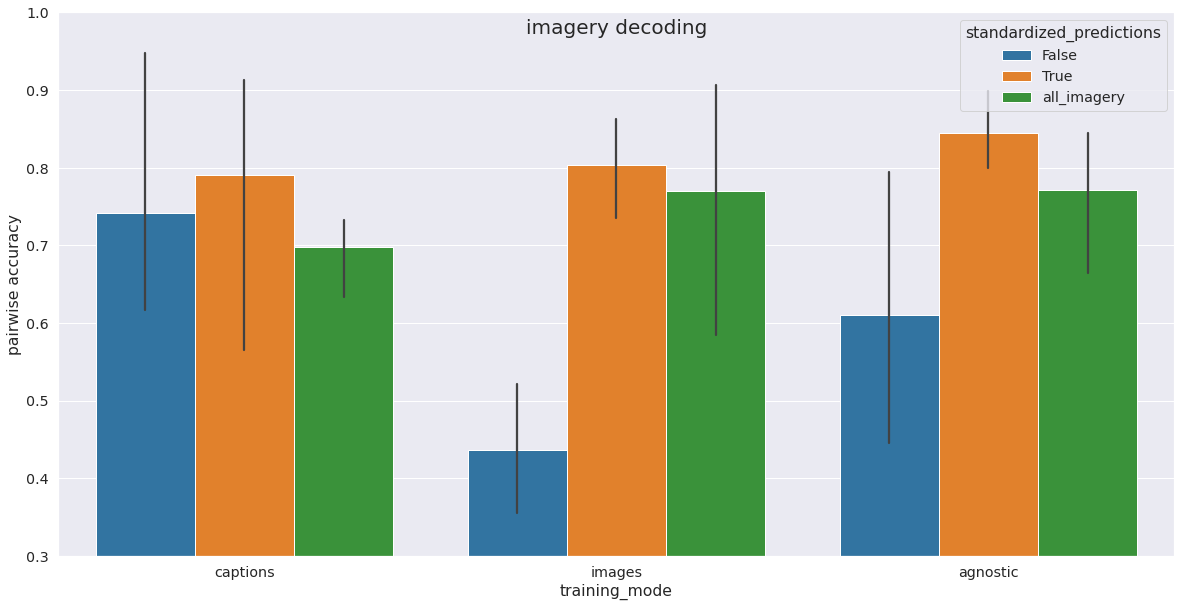

In [37]:
to_plot = data.copy()

LATENT_MODE = 'all_candidate_latents'
# LATENT_MODE = 'limited_candidate_latents'
MASK = 'whole_brain'
TRAINING_SPLITS = 'train'

# to_plot = to_plot[to_plot.standardized_predictions == 'True']
to_plot = to_plot[to_plot.latents == LATENT_MODE]
to_plot = to_plot[to_plot.metric == 'imagery']
to_plot = to_plot[to_plot.training_splits == TRAINING_SPLITS]
to_plot = to_plot[to_plot['mask'] == MASK]

assert len(to_plot) == NUM_SUBJECTS * len(to_plot.standardized_predictions.unique()) * len(to_plot.training_mode.unique())

ORDER = ['captions', 'images', 'agnostic']
# HUE_ORDER = ['imagery', 'imagery_weak']
HUE_ORDER = None

PALETTE = 'tab10'#['red', 'salmon']
sns.set(font_scale=1.3)
plt.figure(figsize=(20,10))
plt.title('imagery decoding', y=0.95, fontsize=20)

ax = sns.barplot(data=to_plot, x="training_mode", y="value", hue="standardized_predictions", order=ORDER, hue_order=HUE_ORDER, palette=PALETTE)
plt.ylabel('pairwise accuracy')
plt.ylim((0.3, 1))
plt.savefig(os.path.join(RESULTS_DIR, f"attention_modulation_imagery.png"), bbox_inches='tight', pad_inches=0, dpi=300)


100%|██████████| 13/13 [00:00<00:00, 272.84it/s]
<ipython-input-48-f45c1de247a4>:41: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  ax = sns.barplot(data=to_plot, x="mask", y="value", hue="metric", hue_order=HUE_ORDER, palette=PALETTE)


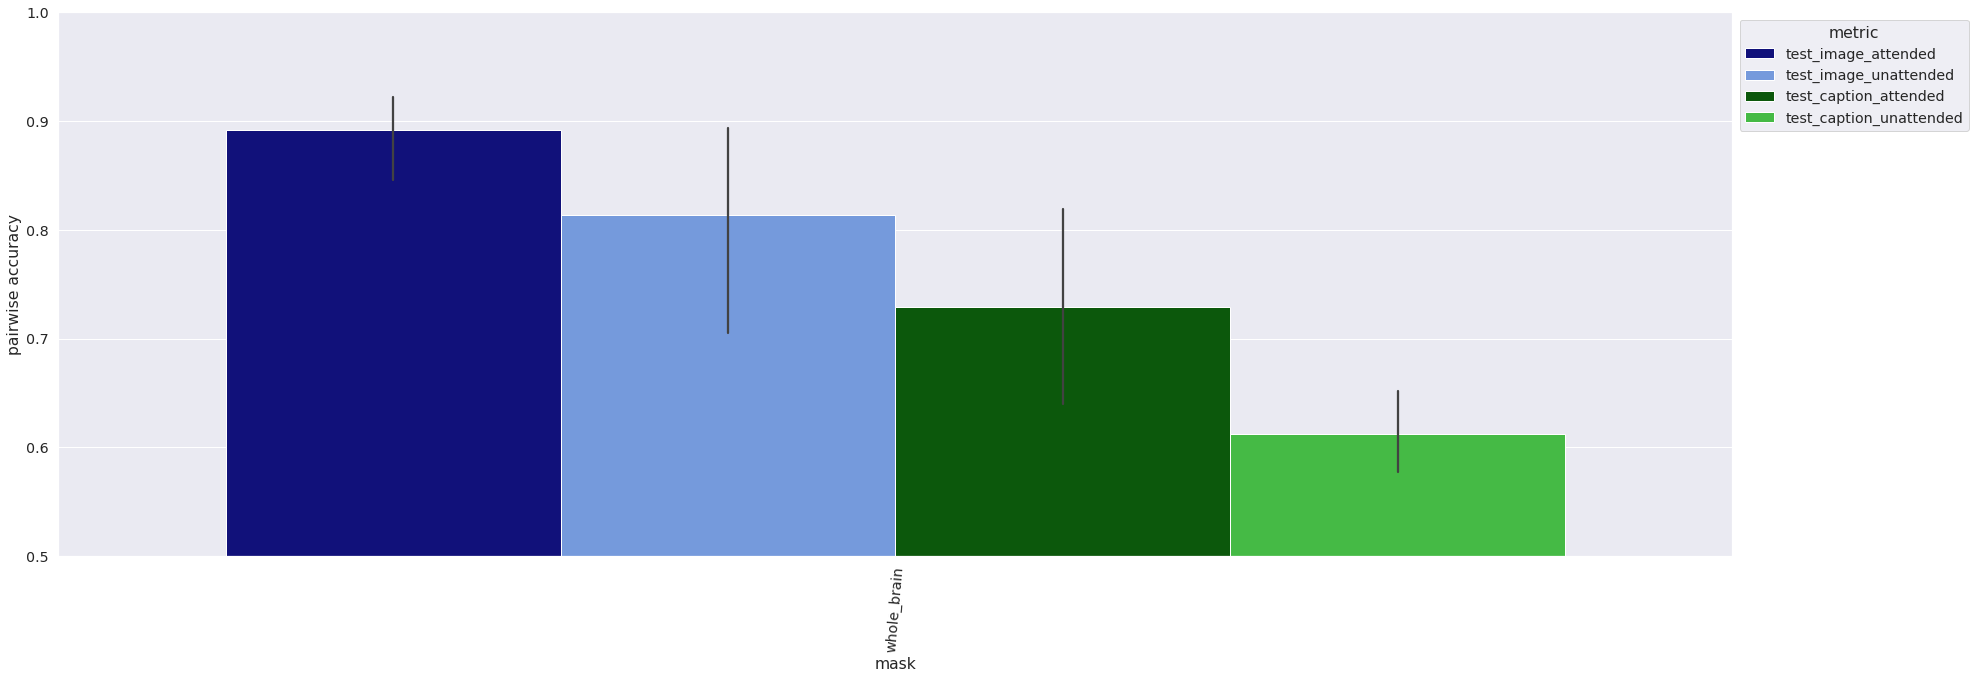

In [48]:
data = load_results_data()

to_plot = data.copy()

# METRIC = "imagery"
TRAINING_MODE = 'agnostic'
# TRAINING_MODE = 'images'
# TRAINING_MODE = 'captions'

LATENT_MODE = 'all_candidate_latents'
# LATENT_MODE = 'limited_candidate_latents'
# MASK = 'whole_brain'

TRAINING_SPLITS = 'train'


to_plot = to_plot[to_plot.standardized_predictions == 'True']
to_plot = to_plot[to_plot.latents == LATENT_MODE]
to_plot = to_plot[to_plot.training_splits == TRAINING_SPLITS]
# to_plot = to_plot[to_plot['mask'] == MASK]

to_plot = to_plot[to_plot.training_mode == TRAINING_MODE]
# to_plot = to_plot[to_plot.metric == METRIC]

def shorten_mask_name(name):
    if name == "whole_brain":
        return name
    return os.path.basename(name)
    
to_plot["mask"] = to_plot["mask"].apply(shorten_mask_name)


# print(to_plot.groupby(['metric', 'mask']).agg(num_subjects=('value', 'size')).reset_index())
assert len(to_plot) == NUM_SUBJECTS * len(to_plot.metric.unique()) * len(to_plot['mask'].unique())


HUE_ORDER = ['test_image_attended', 'test_image_unattended', 'test_caption_attended', 'test_caption_unattended']#, 'imagery', 'imagery_weak'] #'test_image',  'test_caption',
PALETTE = ['darkblue', 'cornflowerblue', 'darkgreen', 'limegreen', 'red', 'salmon'] #'blue', 'green'
sns.set(font_scale=1.3)
plt.figure(figsize=(30,10))
ax = sns.barplot(data=to_plot, x="mask", y="value", hue="metric", hue_order=HUE_ORDER, palette=PALETTE)
plt.ylabel('pairwise accuracy')
plt.ylim((0.5, 1))
plt.xticks(rotation=85)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

